In [6]:
import kaggle
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Получение данных

Данные полученны с помощью kaggle.api

In [7]:
def load_data_from_kaggle(name_datasets):
    kaggle.api.authenticate()
    download_folder = 'datasets'
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
        kaggle.api.competition_download_files(name_datasets, path=download_folder)
        archive_path = os.path.join(download_folder, f'{name_datasets}.zip')
        extract_folder = download_folder

        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        os.remove(archive_path)

In [8]:
name_datasets = 'house-prices-advanced-regression-techniques'
load_data_from_kaggle(name_datasets)

In [9]:
housing = pd.read_csv("datasets/train.csv")

In [10]:
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
housing.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


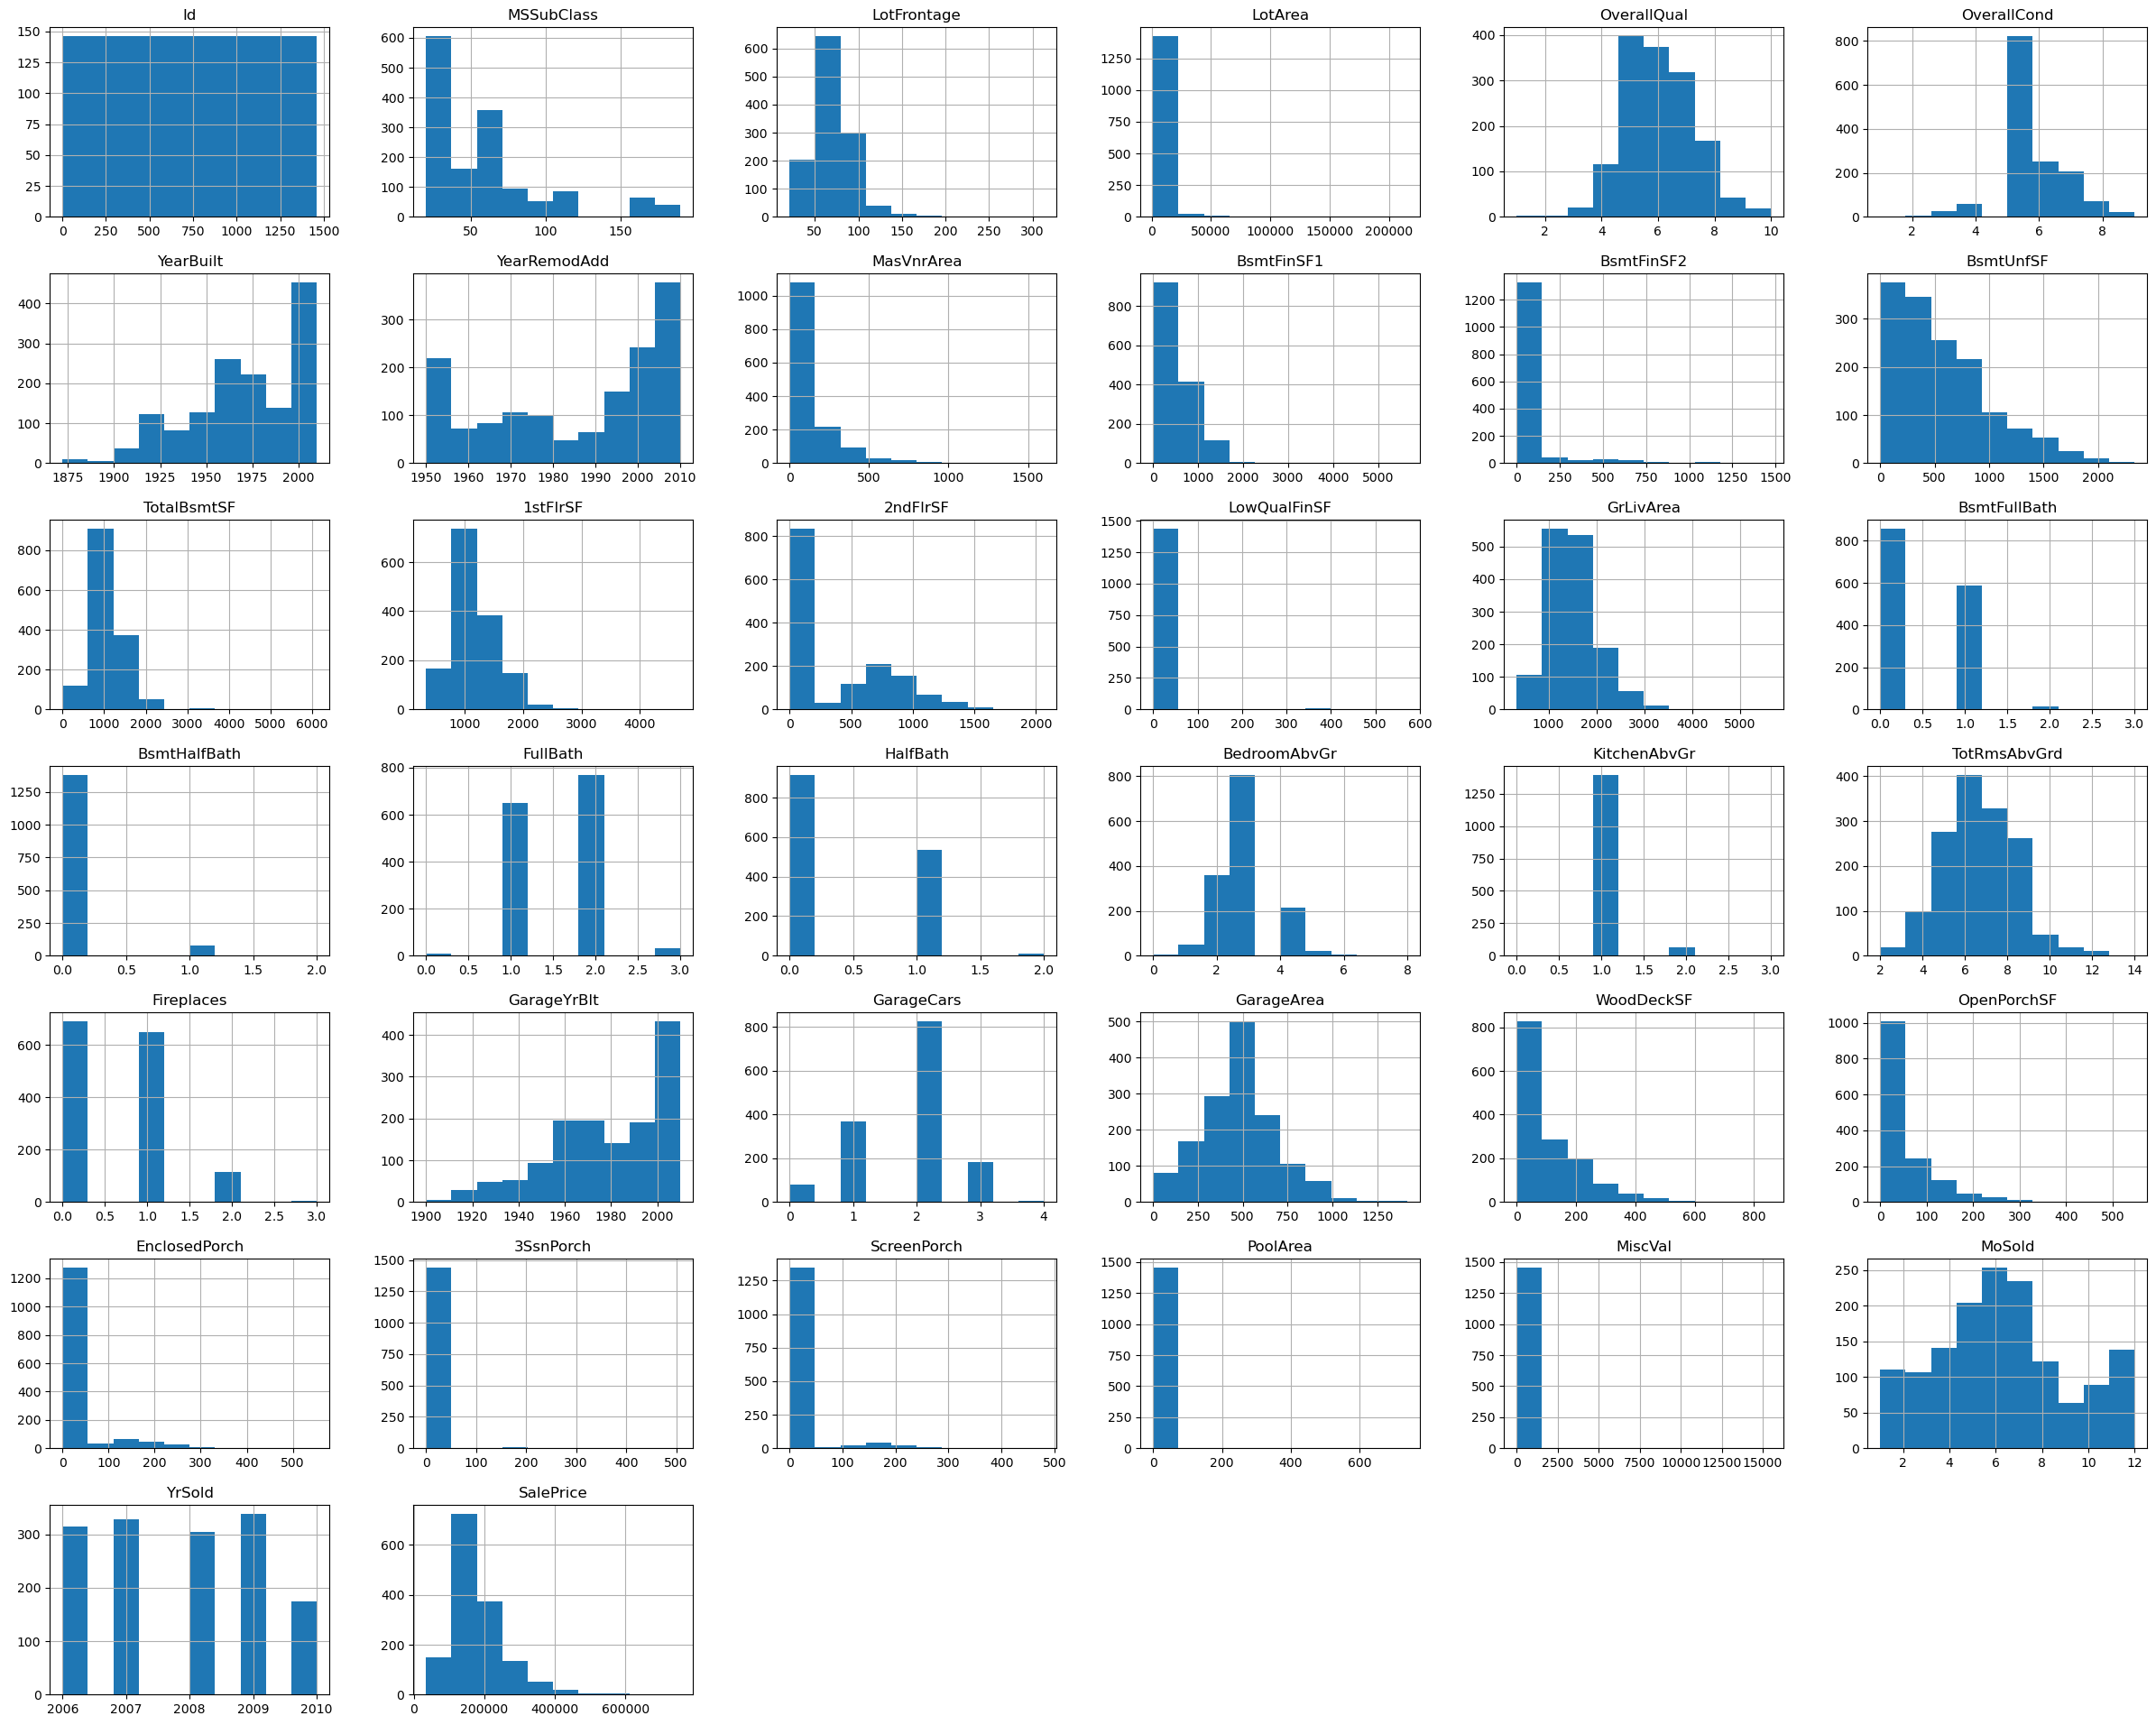

In [13]:
housing.hist(figsize=(30, 24))
plt.show()

# Изучение данных

Делаем копию данных. Поскольку мы собираемся экспериментировать с различными преобразованиями полного обучающего набора, нам следует сделать копию оригинала, чтобы впоследствии вернуться к нему

In [14]:
housing_copy = housing.copy()

## Столбцы тип object

In [15]:
type_object = housing_copy.select_dtypes(include=['object']).columns
type_object

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

## Cтолбцы тип int64

In [16]:
type_int64 = housing_copy.select_dtypes(include=['int64']).columns
type_int64

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

## Столбцы тип float64

In [17]:
type_float64 = housing_copy.select_dtypes(include=['float64']).columns
type_float64

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

## Пропущеные значения

Общий % пустных значений

In [18]:
housing_copy.isnull().mean().mean() * 100

np.float64(6.620158971757147)

% пустных значений в каждой колонке

In [19]:
col_null = housing_copy.columns[housing_copy.isnull().any()]
housing_copy[col_null].isnull().mean() * 100

LotFrontage     17.739726
Alley           93.767123
MasVnrType      59.726027
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

## Шумность данных

Функция для выявлениея и визуализация шума в данных

In [20]:
def detect_and_visualize_noise(data, threshold=3):
    """
    Функция для выявления и визуализации шума в данных DataFrame или Series с использованием Z-оценки.
    
    Параметры:
    data (pd.DataFrame или pd.Series): Входные данные.
    threshold (float): Пороговое значение Z-оценки для определения выбросов. По умолчанию 3.
    
    Возвращает:
    outliers_dict (dict): Словарь с информацией о выбросах для каждого признака или серии.
    """
    def process_series(series, threshold):
        """Обрабатывает одну серию данных, выявляя и визуализируя выбросы."""
        series_data = series.dropna()  # Удаляем пропущенные значения для анализа
        z_scores = np.abs(stats.zscore(series_data))  # Вычисляем Z-оценки
        outlier_indices = np.where(z_scores > threshold)[0]  # Определяются индексы выбросов
        outlier_values = series_data.iloc[outlier_indices]  # Извлекаются значения выбросов

        # Визуализация данных и выбросов
        plt.figure(figsize=(12, 6))
        plt.plot(series_data.index, series_data, 'o', label='Исходные данные')
        plt.plot(outlier_values.index, outlier_values, 'ro', 
                 label=f'Выбросы (кол-во: {len(outlier_indices)})')
        plt.title(f'Выявление выбросов в данных: {series.name}')
        plt.xlabel('Индекс')
        plt.ylabel('Значение')
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close() 

    # Проверка, является ли входной объект DataFrame или Series
    if isinstance(data, pd.DataFrame):
        for column in data.columns:
            process_series(data[column], threshold)
    elif isinstance(data, pd.Series):
        process_series(data, threshold)
    else:
        raise TypeError("Входные данные должны быть DataFrame или Series.")

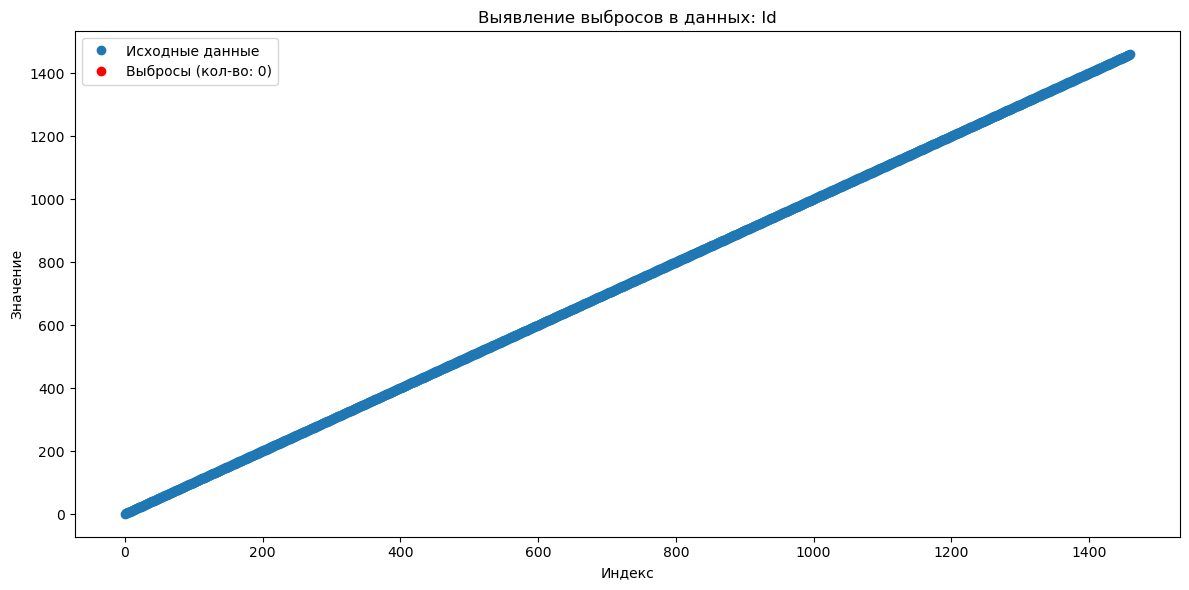

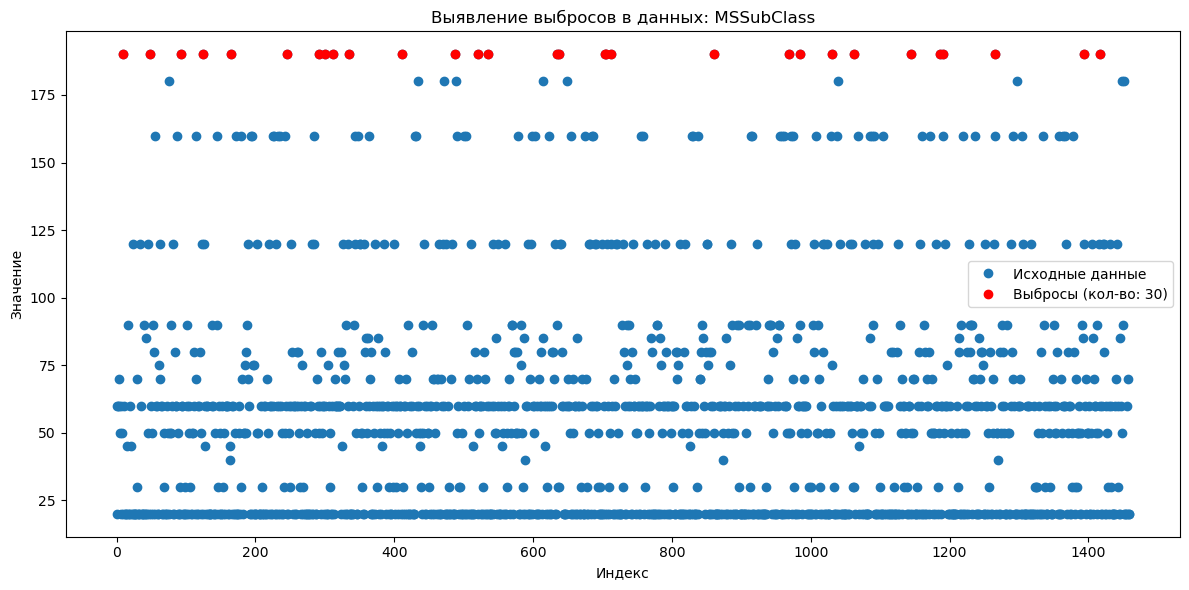

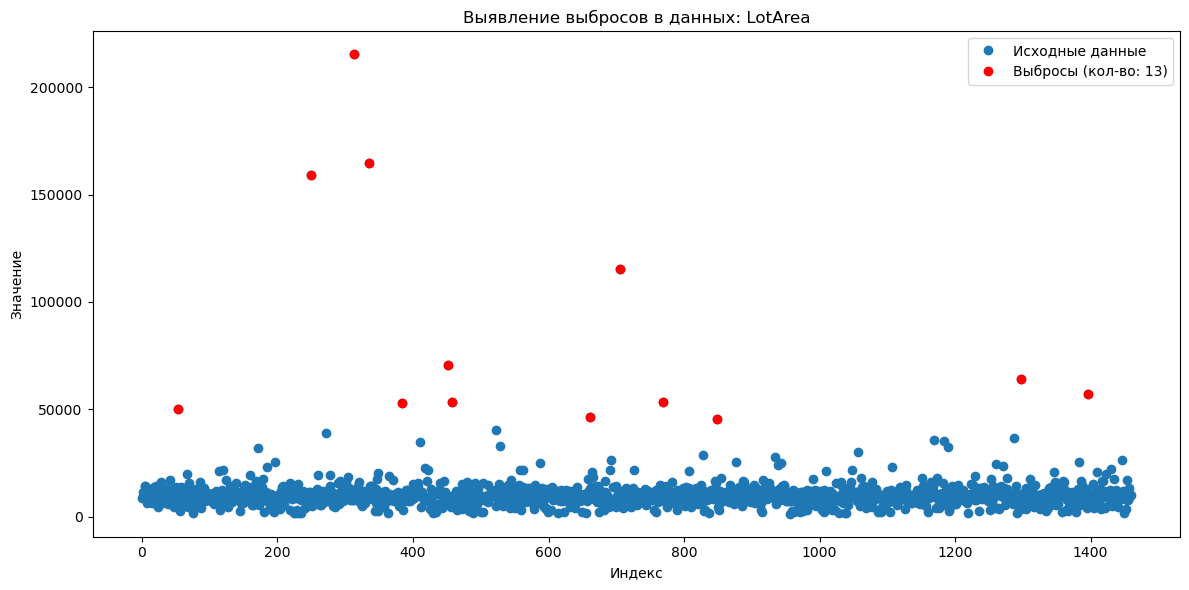

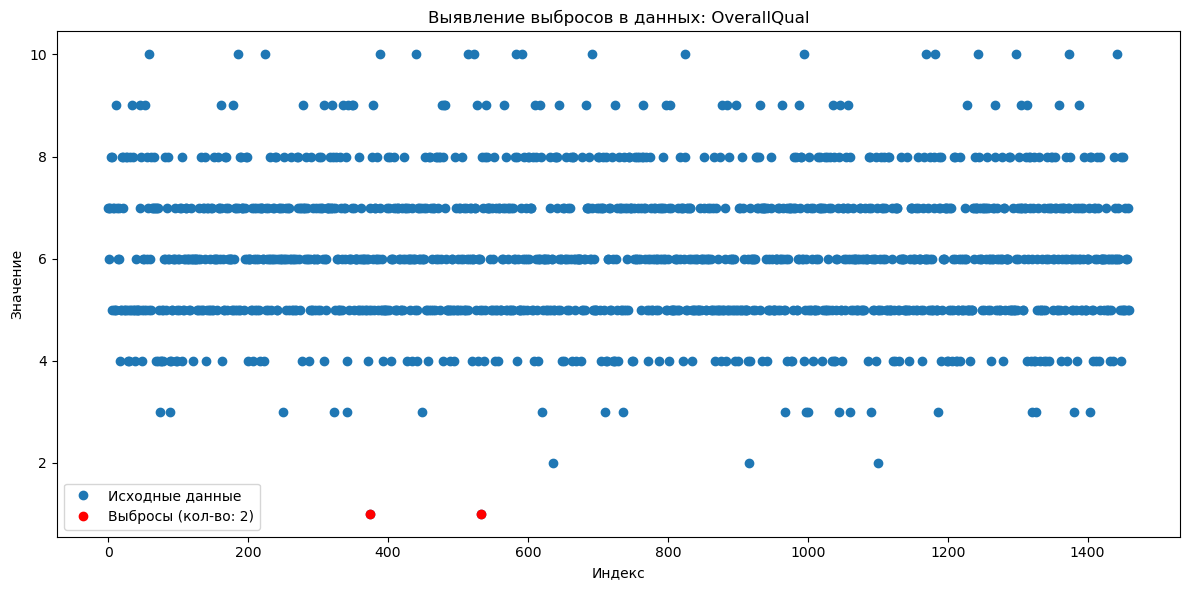

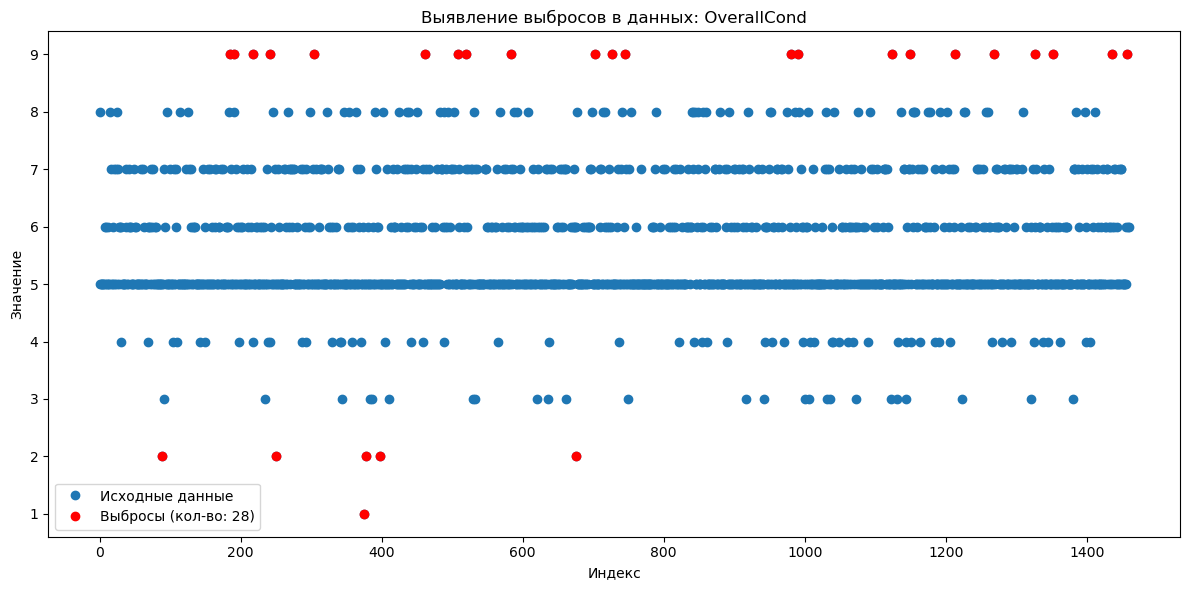

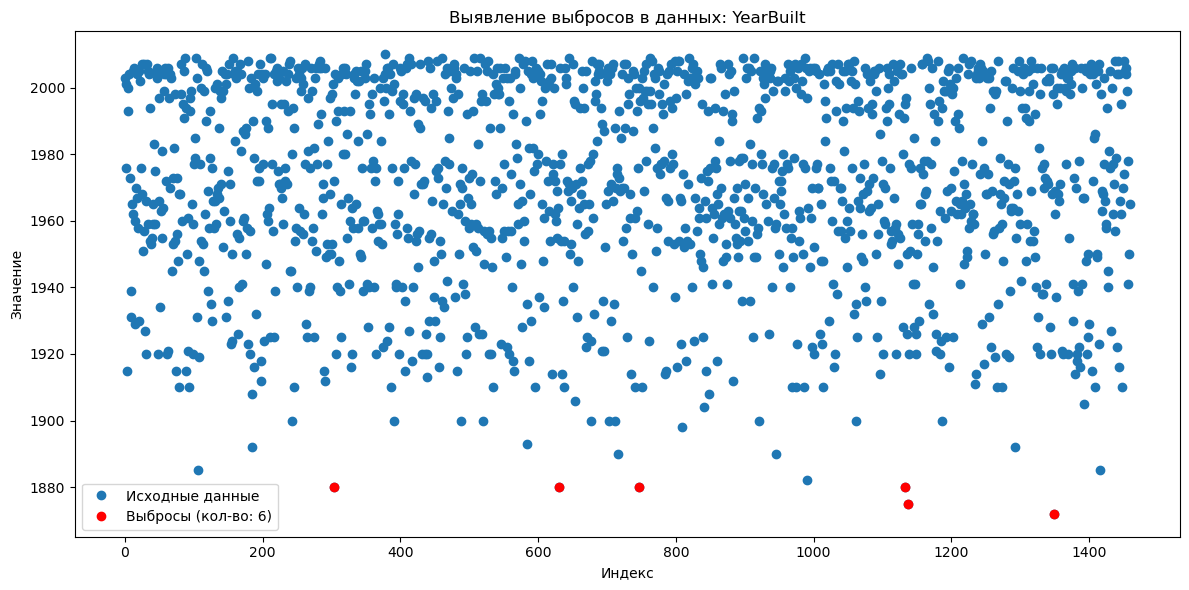

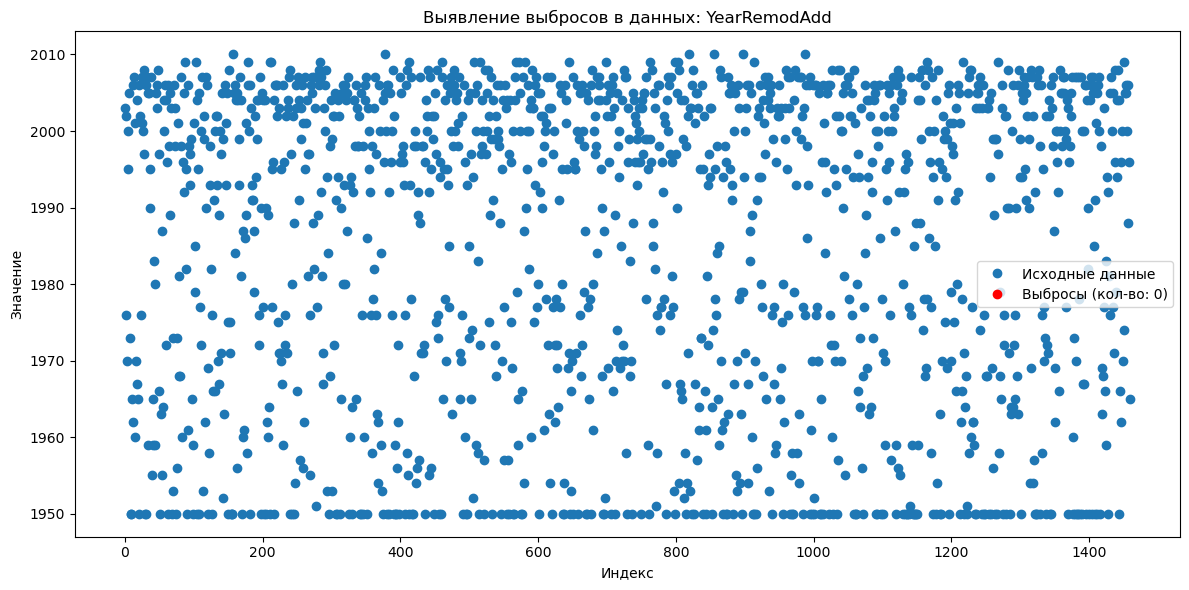

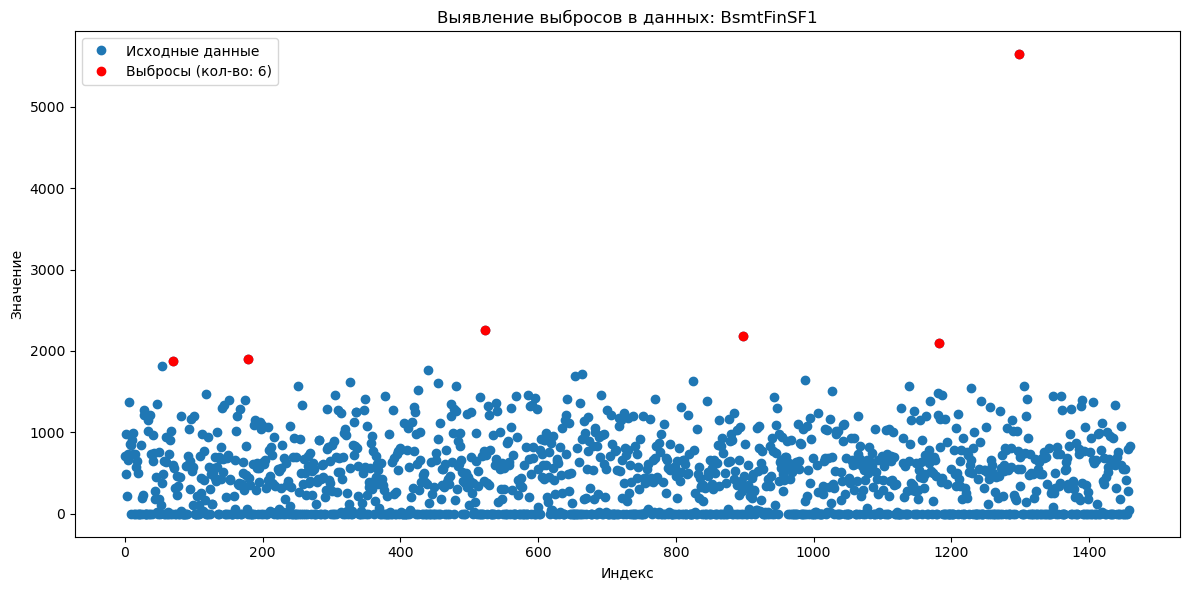

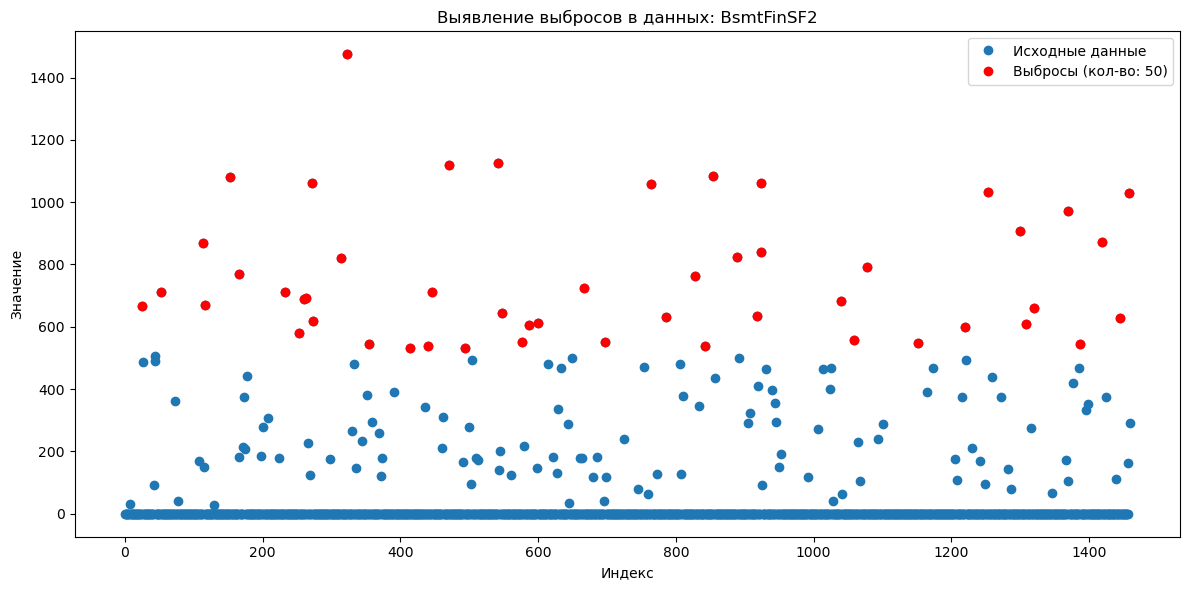

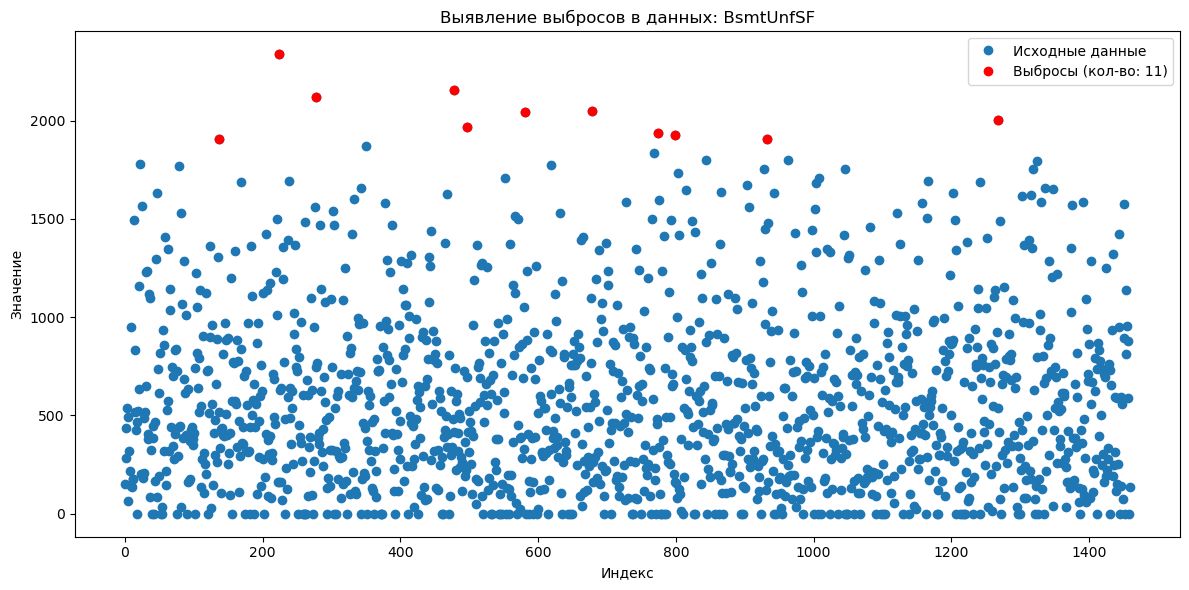

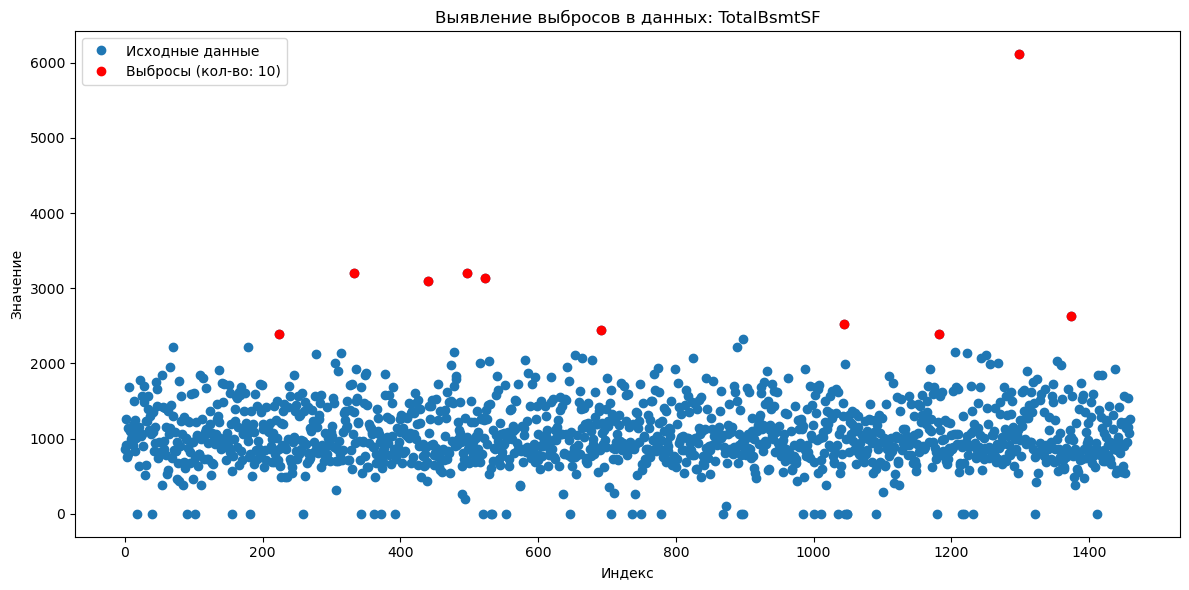

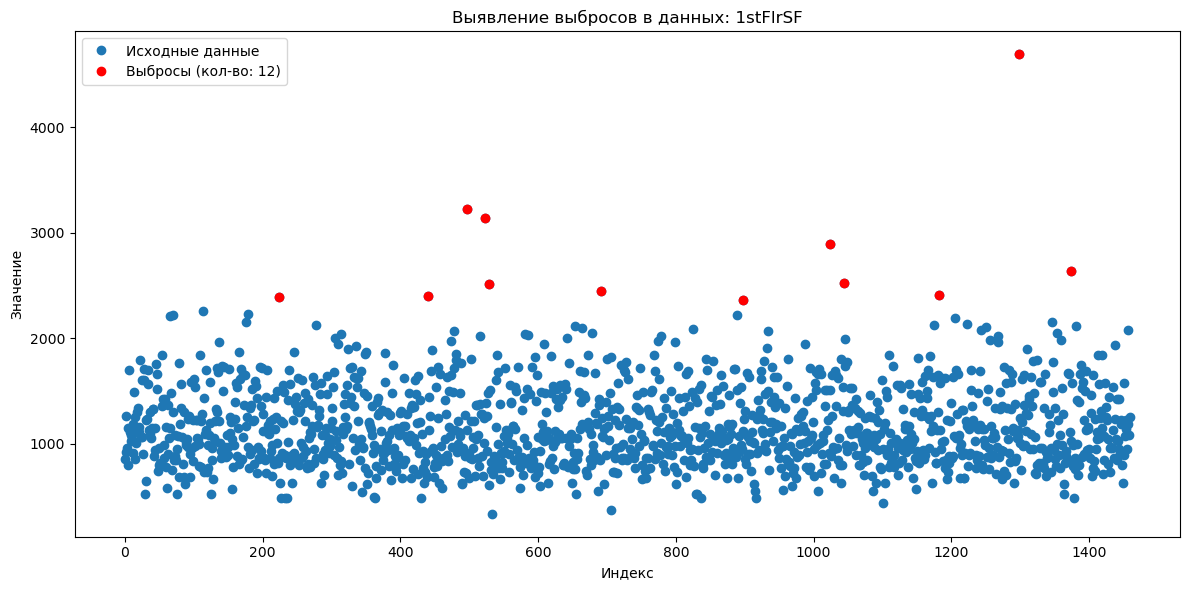

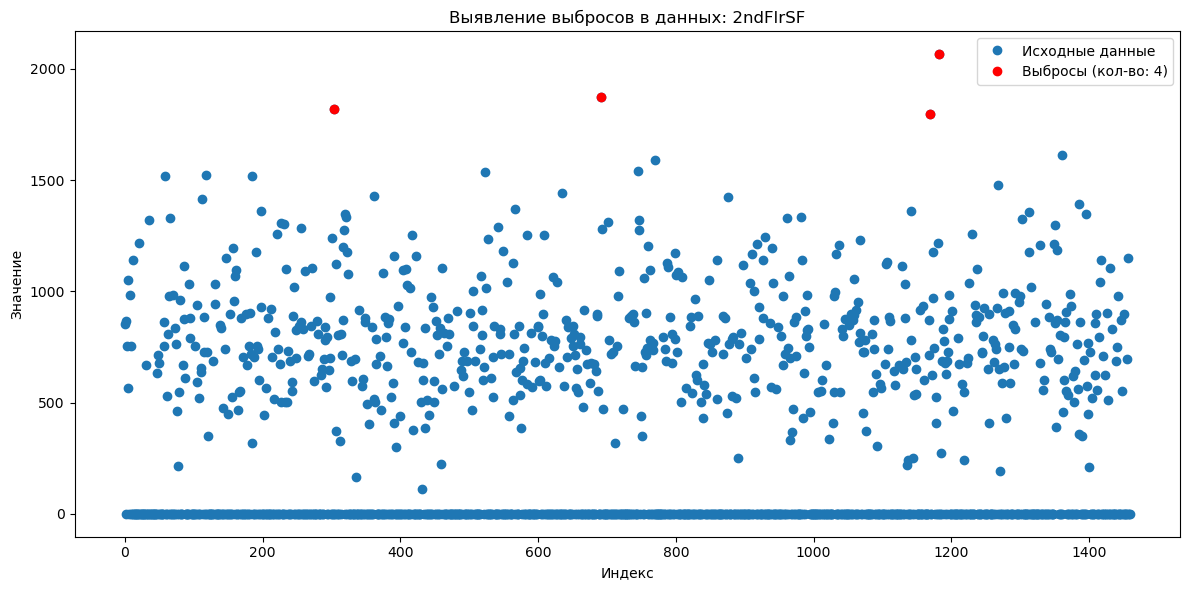

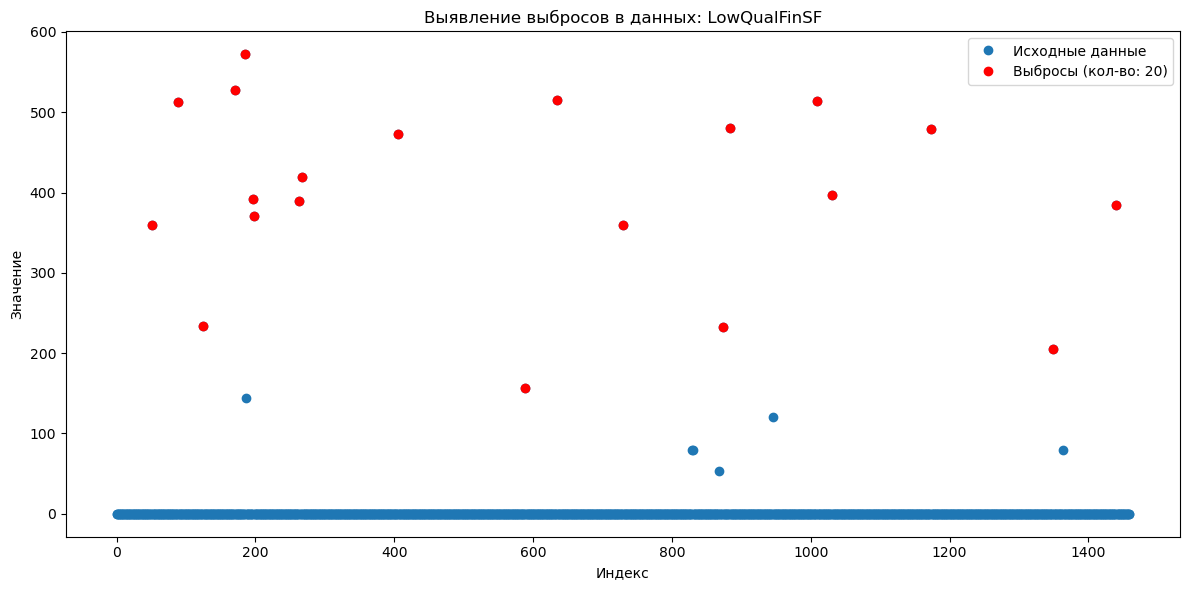

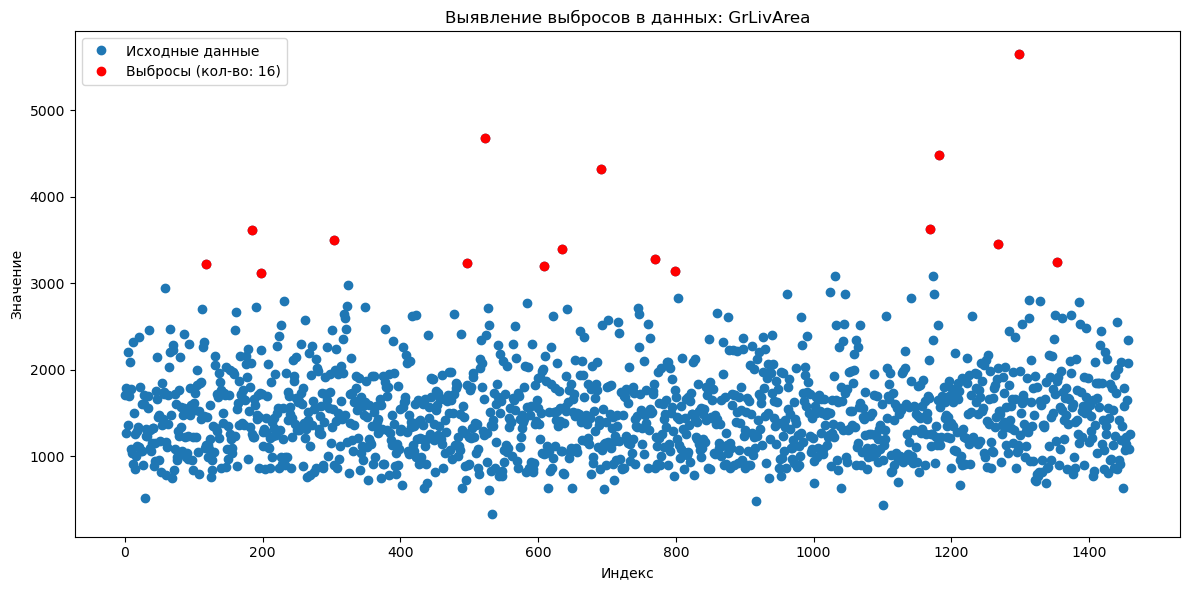

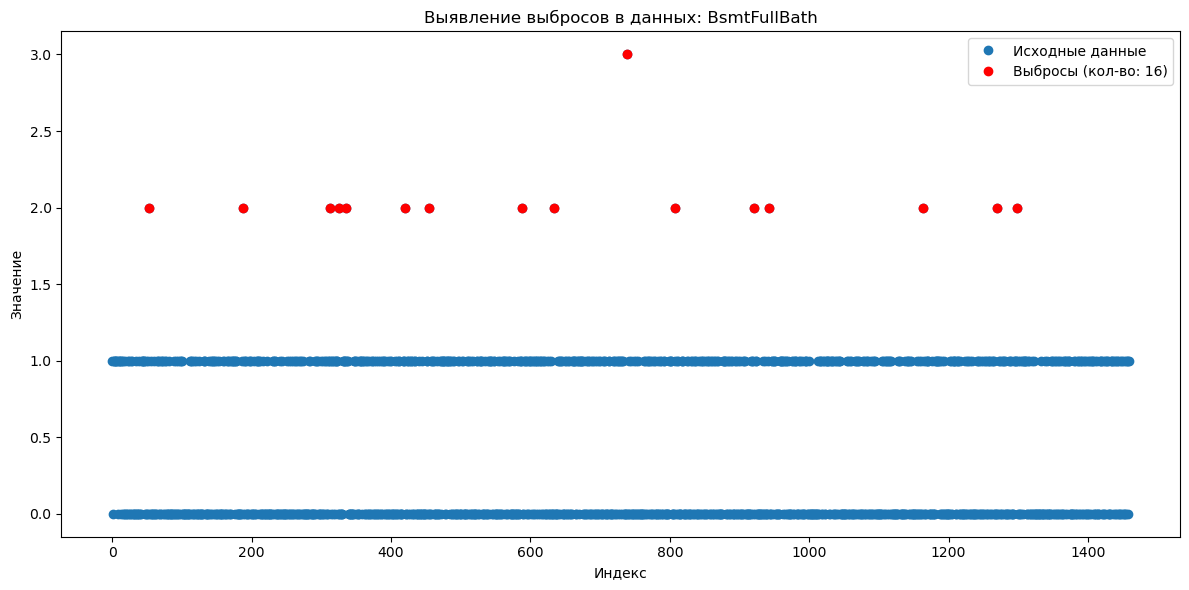

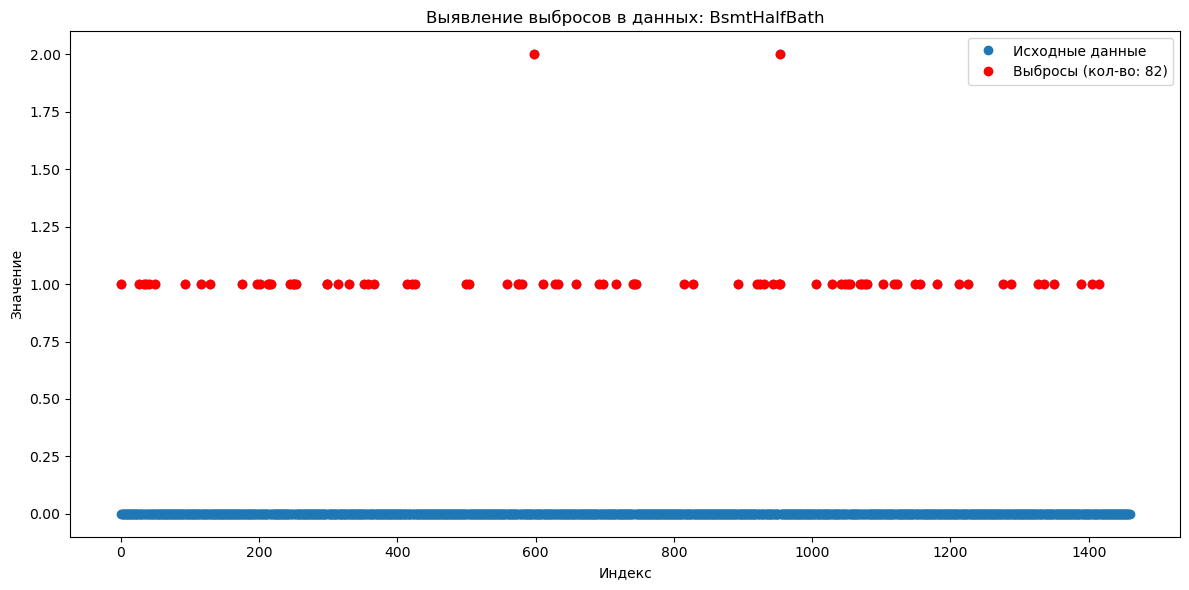

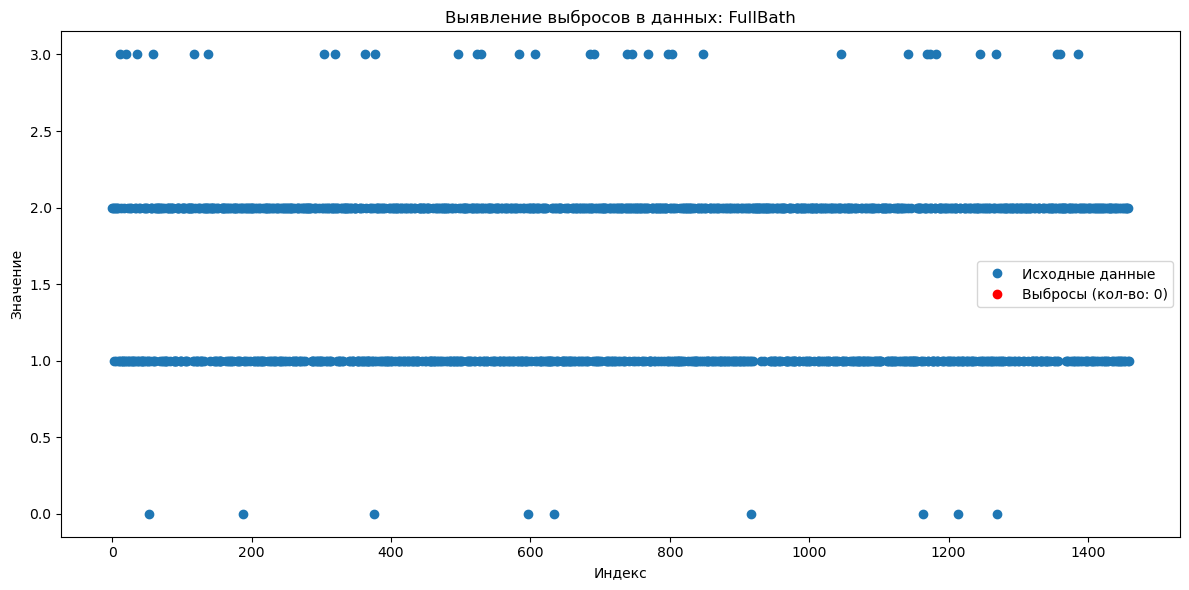

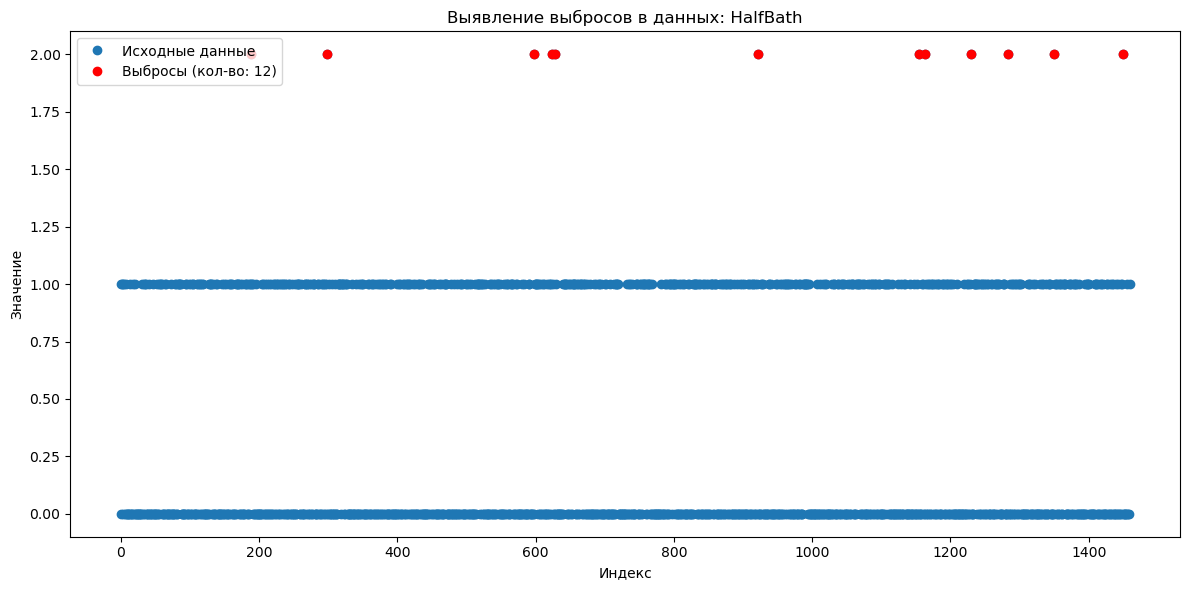

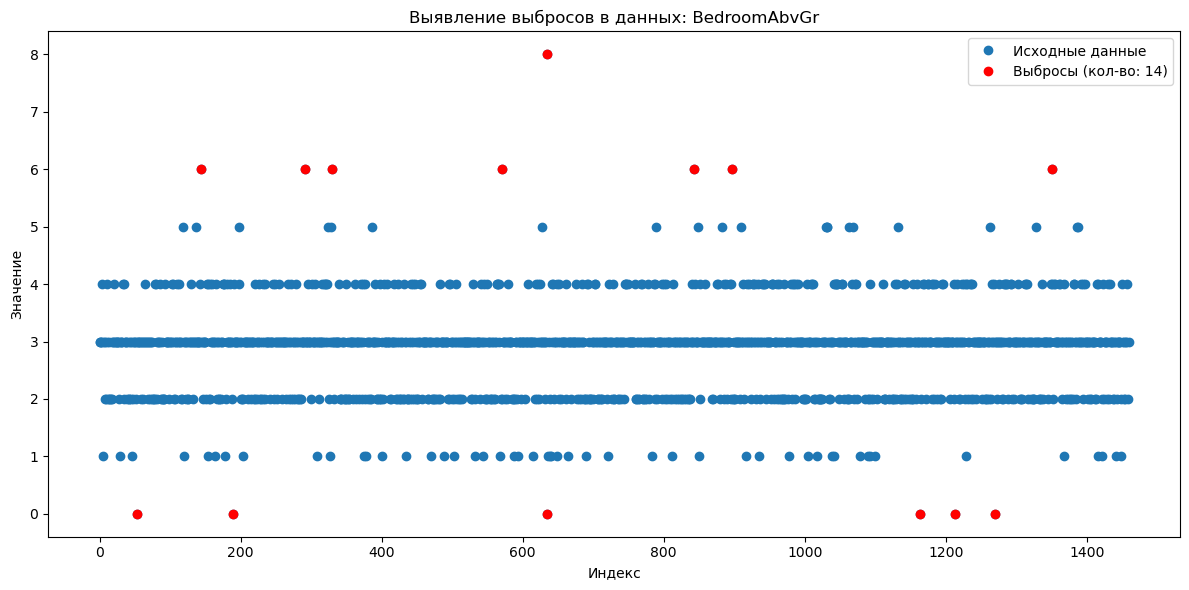

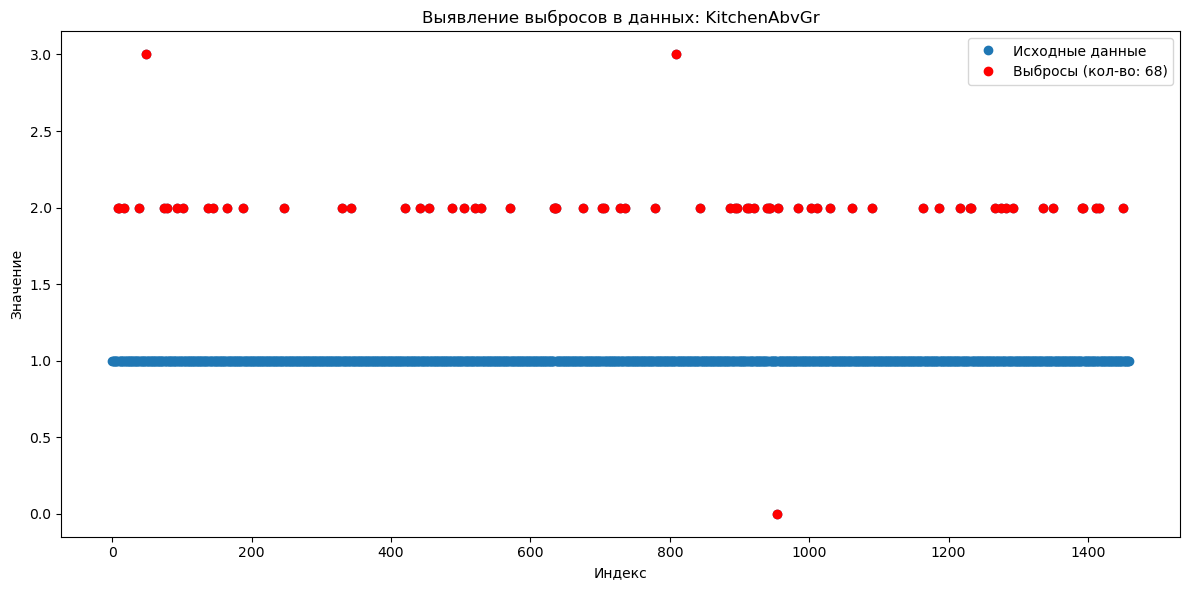

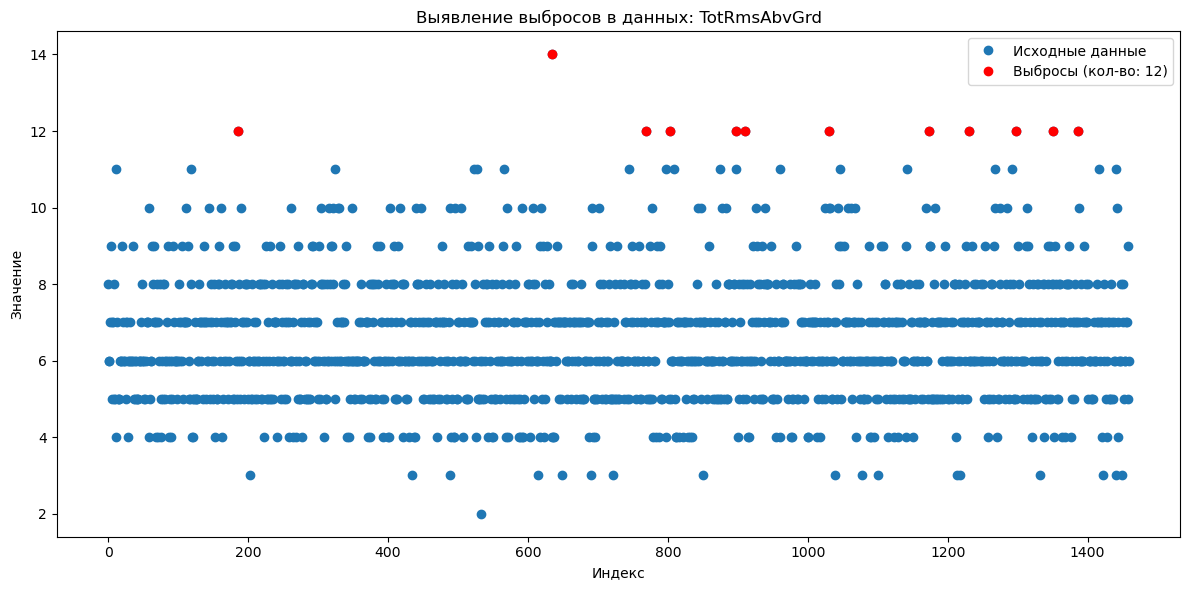

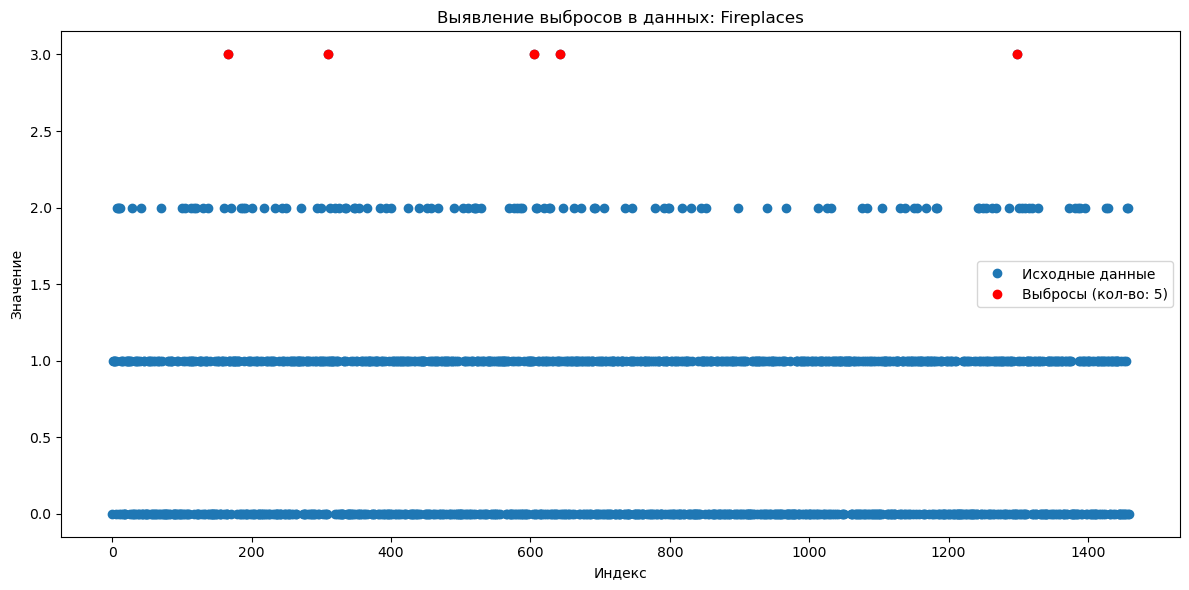

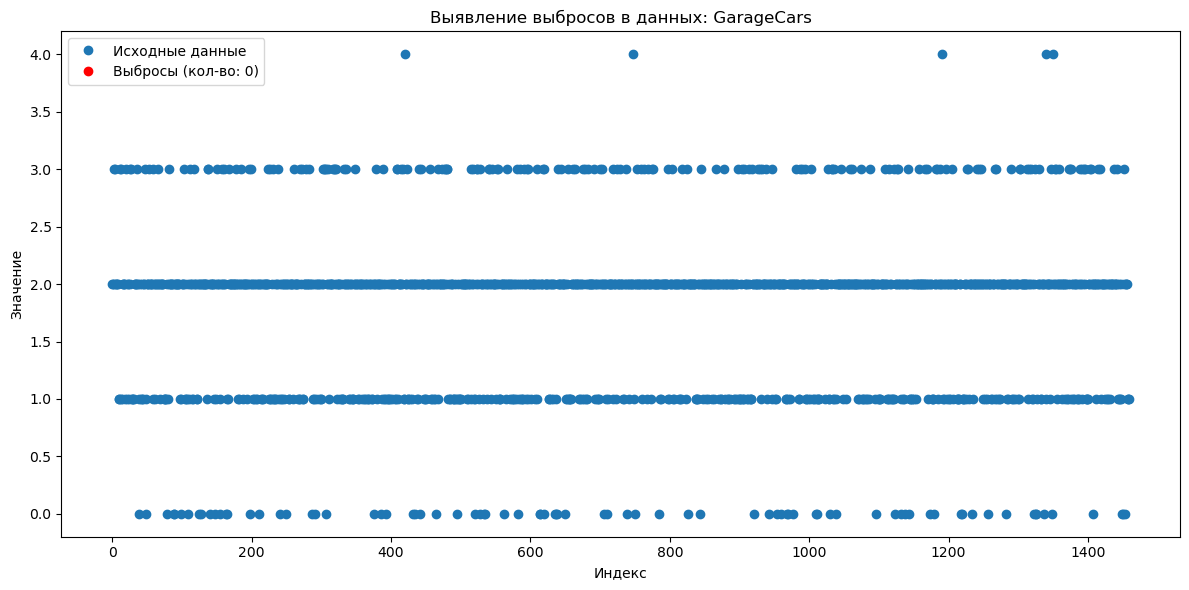

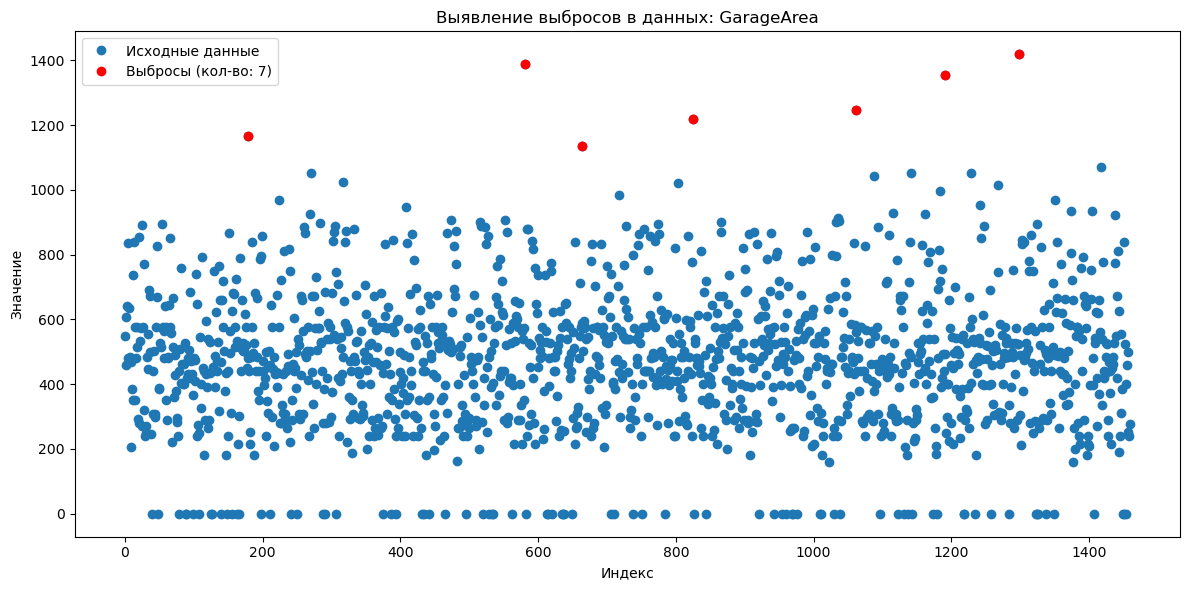

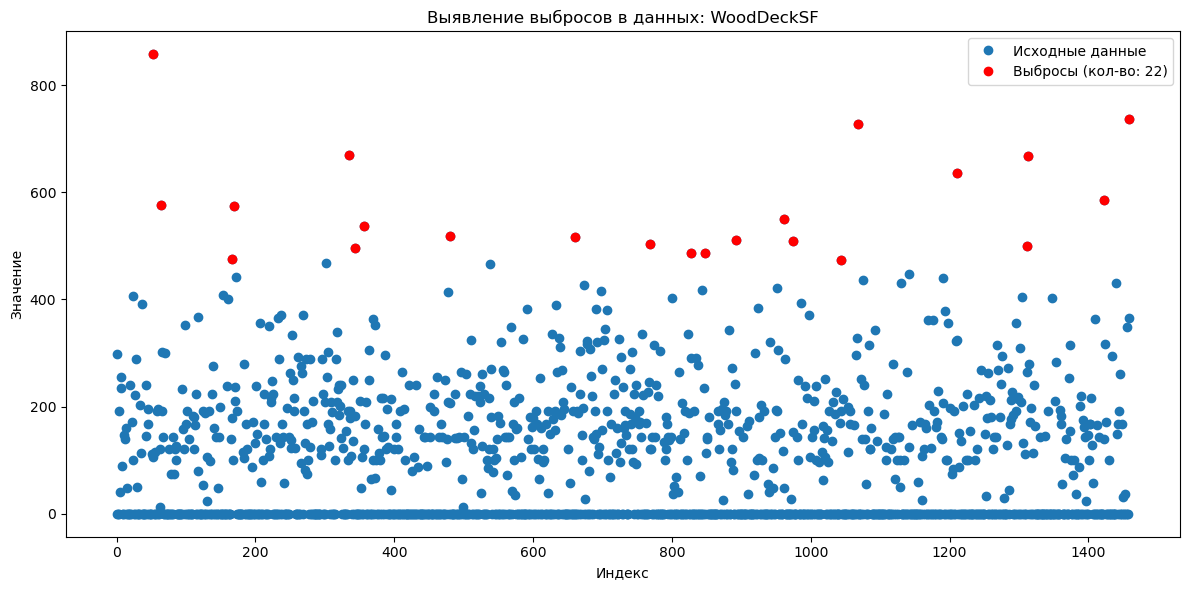

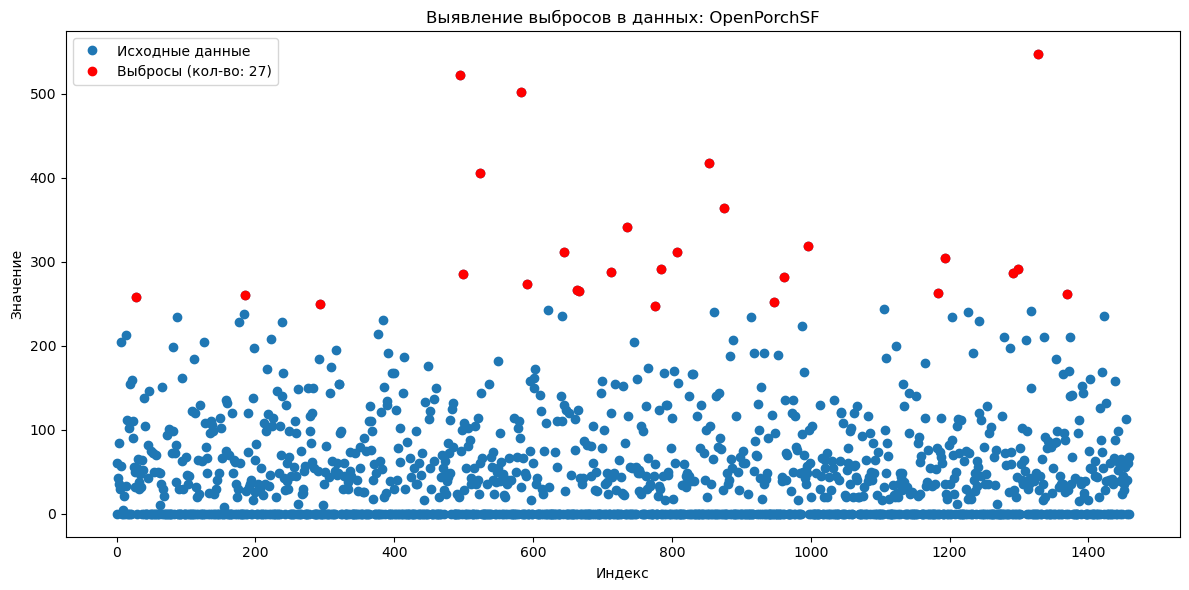

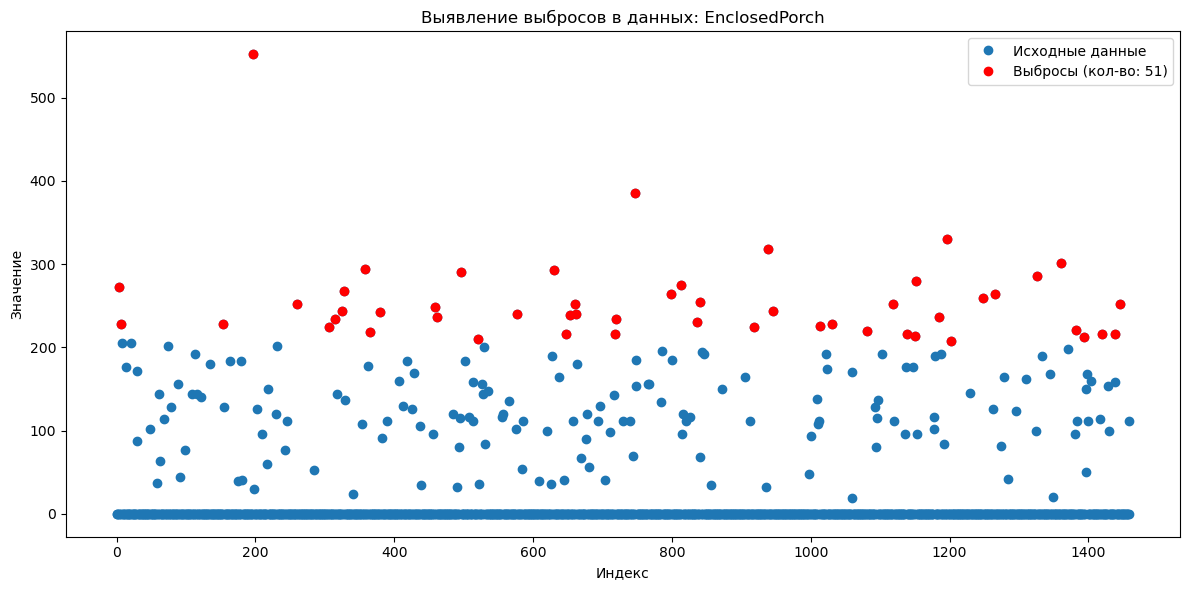

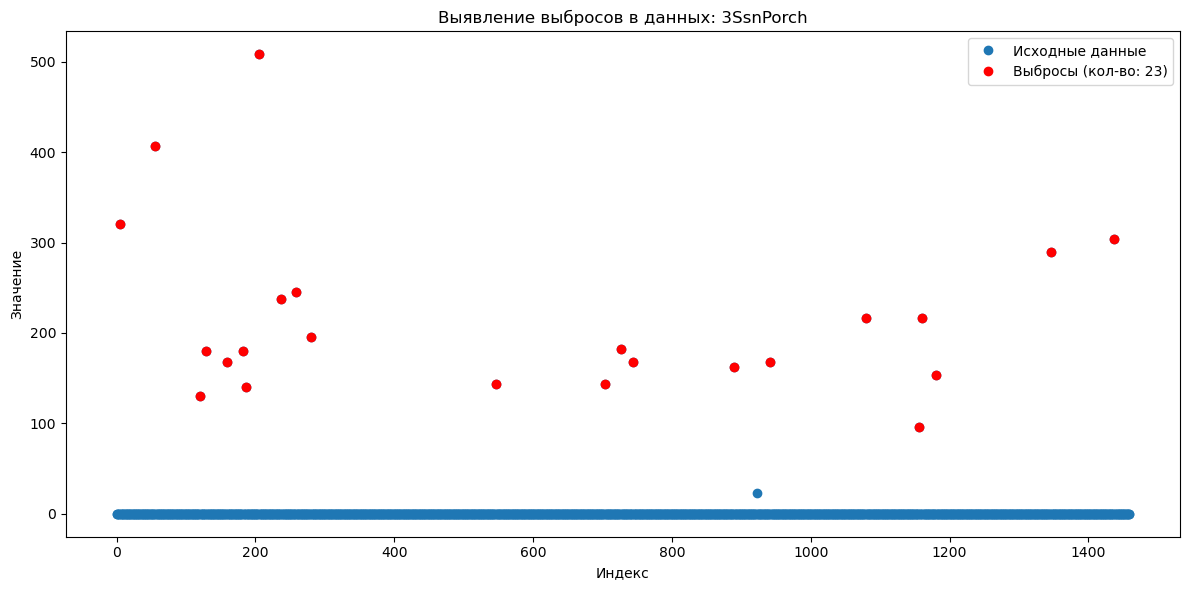

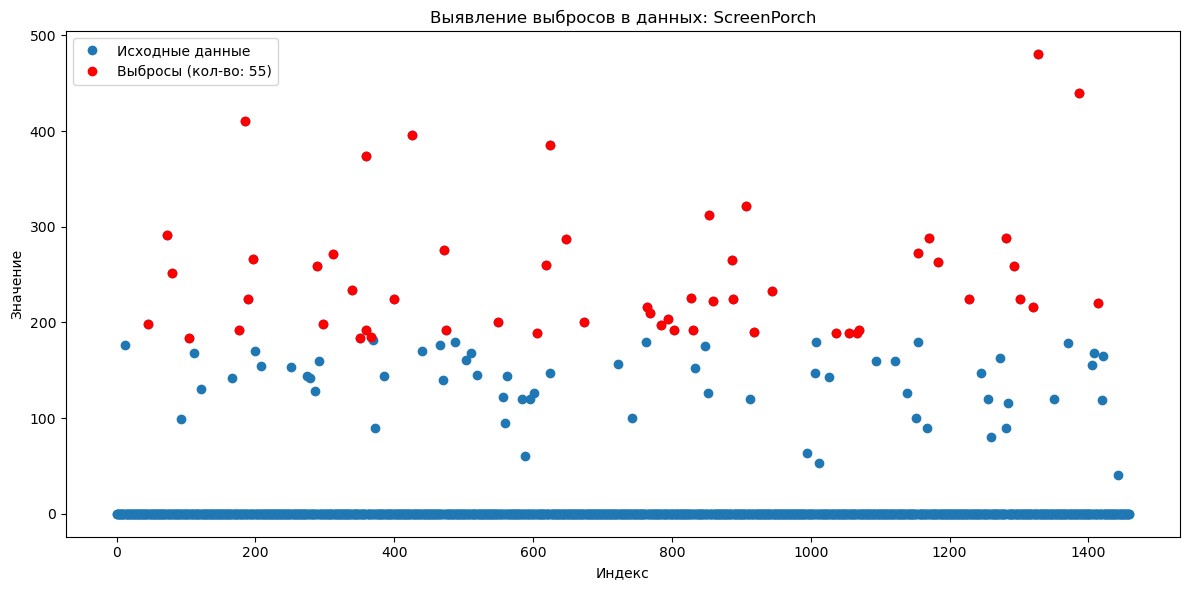

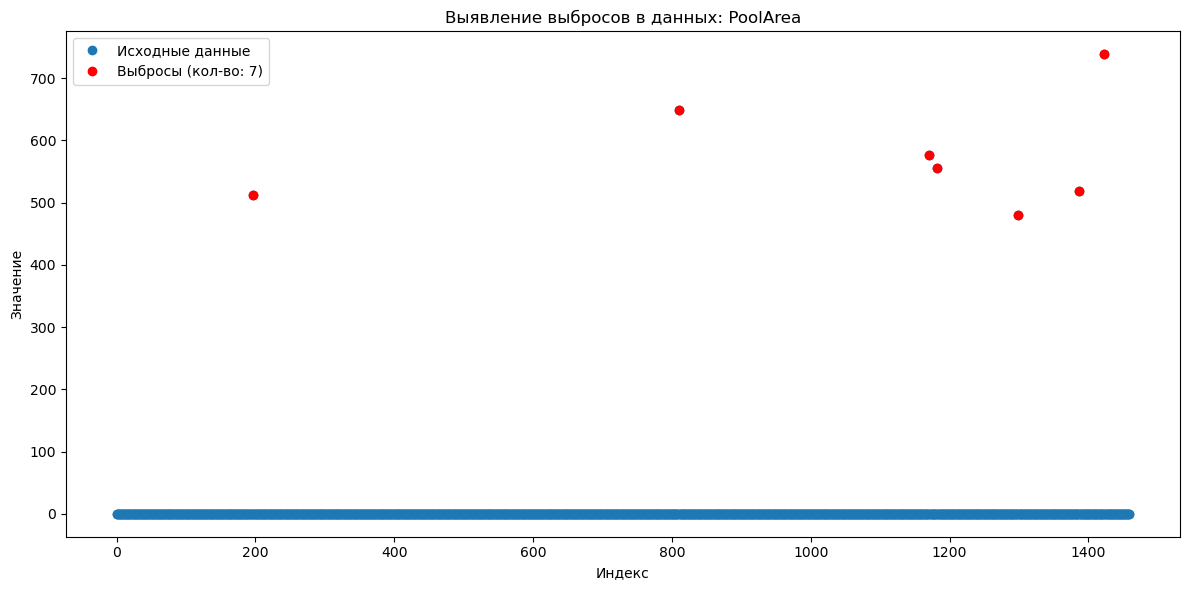

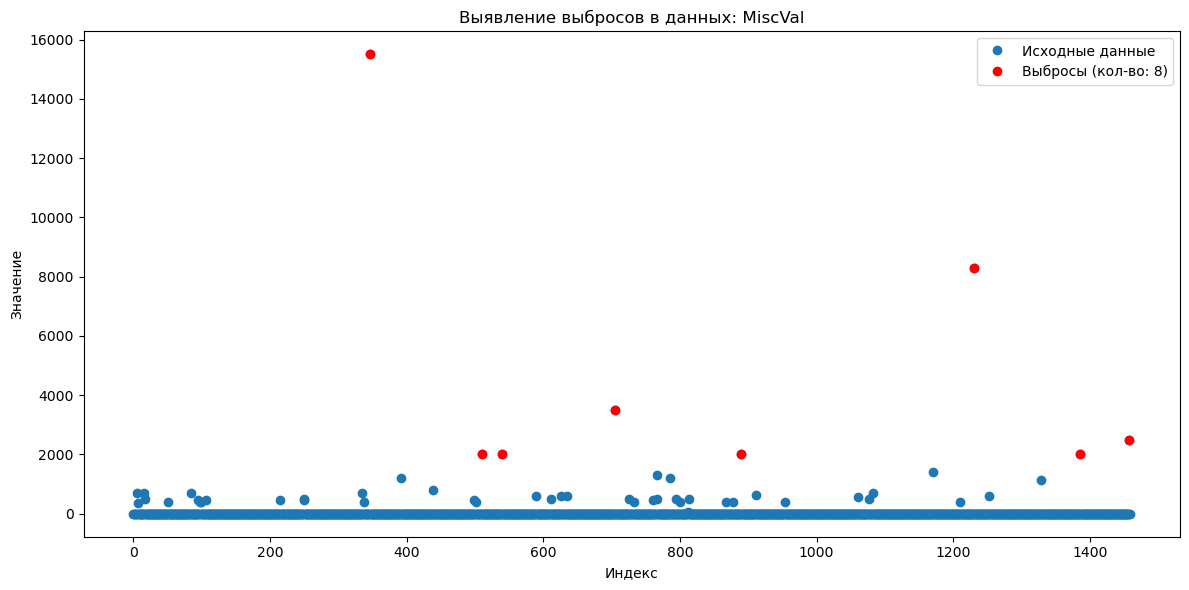

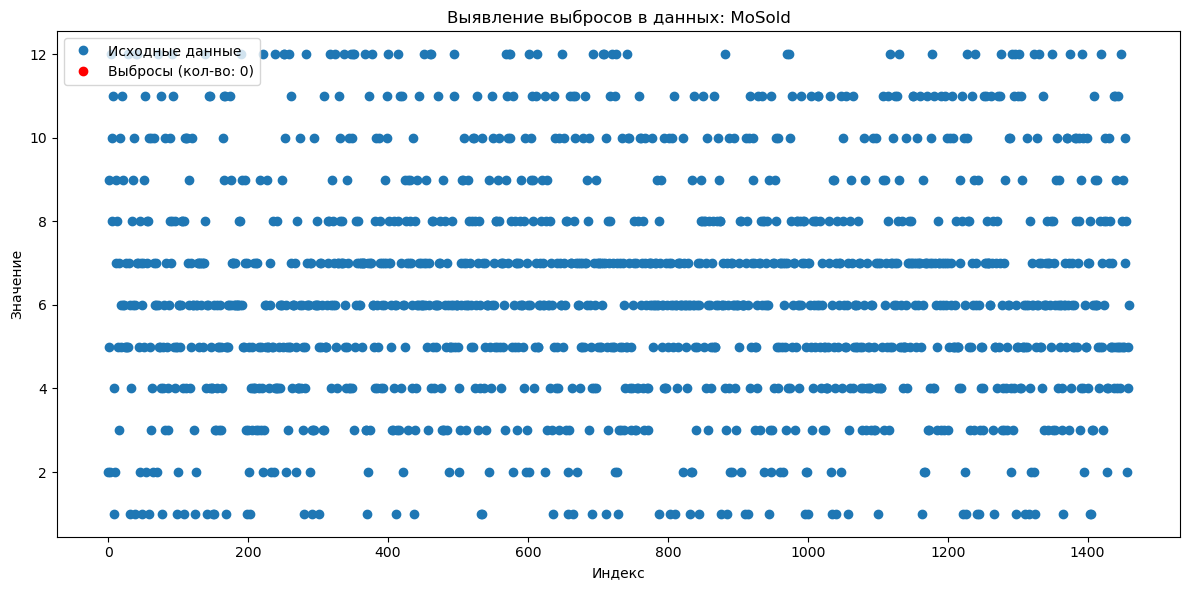

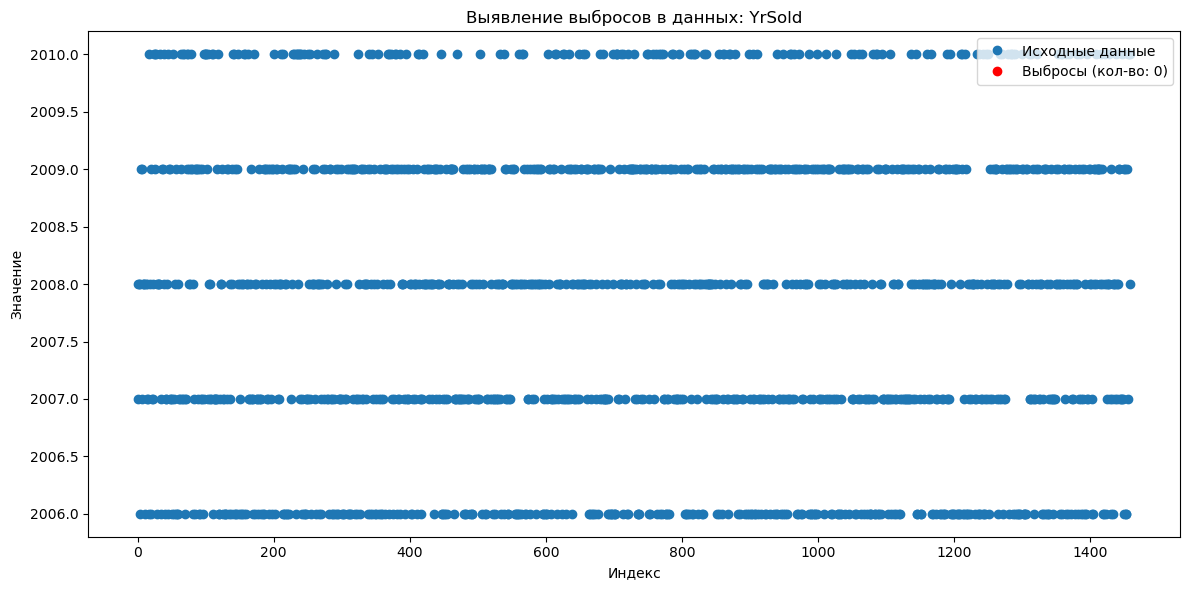

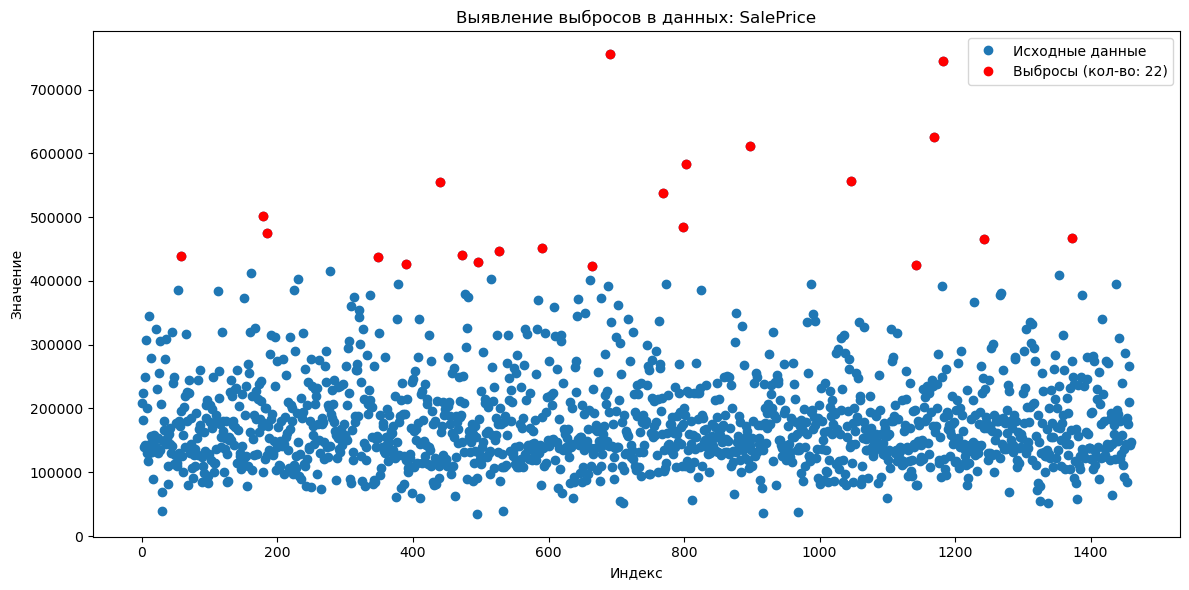

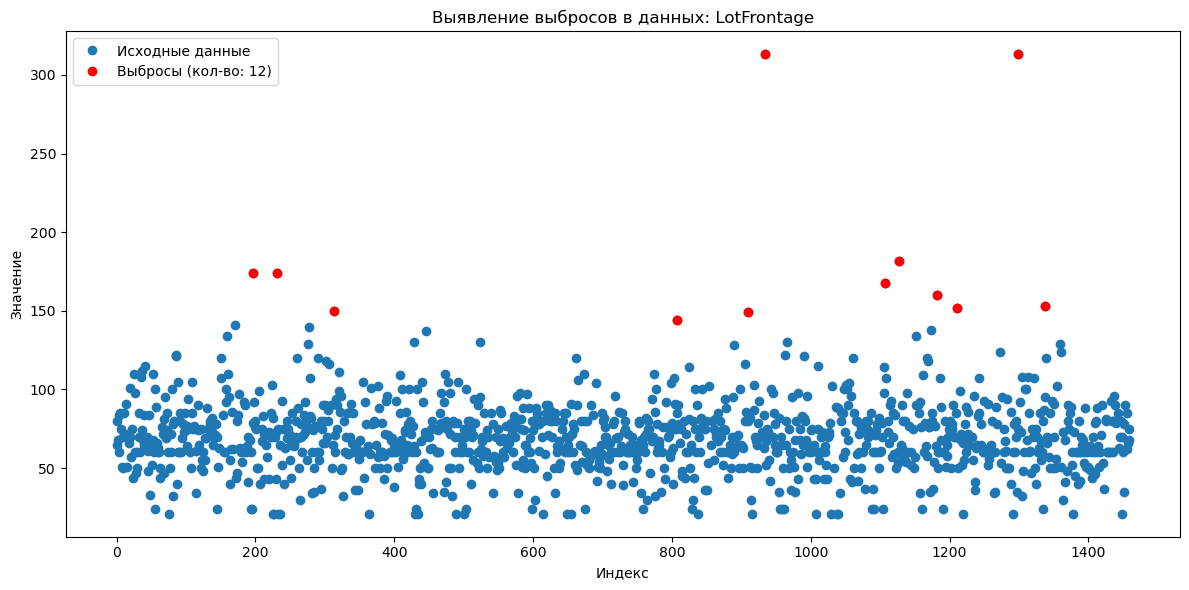

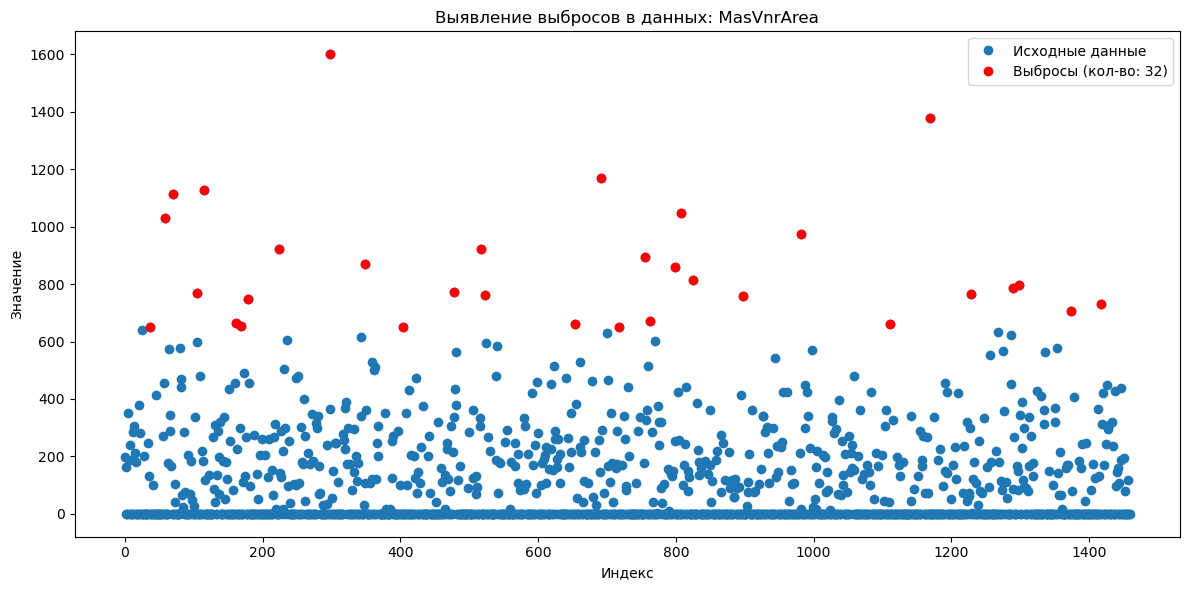

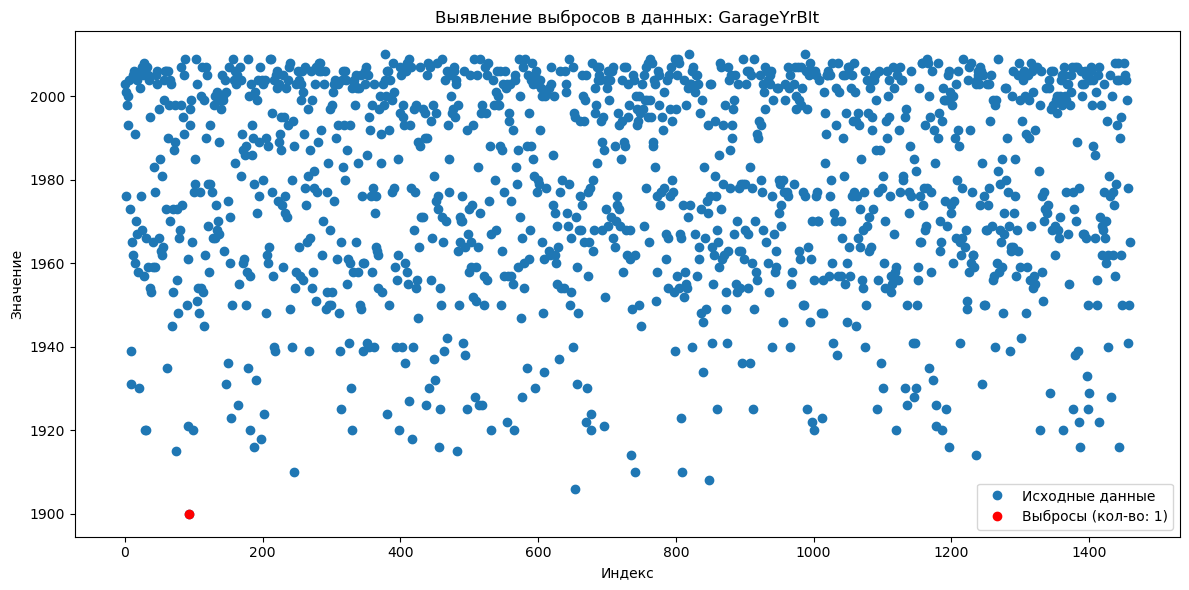

In [21]:
detect_and_visualize_noise(housing_copy[type_int64])
detect_and_visualize_noise(housing_copy[type_float64])

# Вычисляем стандартный коэффициент корреляции

In [16]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr